In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from skopt import BayesSearchCV

In [2]:
#读取CSV文件
csv_file_path = "C:/Users/Lenovo/Desktop/new_study/CNS/output/ASP_filtering.csv"
df = pd.read_csv(csv_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Columns: 396 entries, SEQUENCE to LABEL
dtypes: float64(388), int64(7), object(1)
memory usage: 3.6+ MB


In [3]:
#获取因变量标签
y=df["LABEL"]
#获得自变量标签
#保障数据格式是DataFrame,去除不需要进行特征提取的LABEL、SEQUENCE、MIC
X = df.drop(columns=["LABEL","SEQUENCE","MIC"])

In [4]:
# 初始化 XGBoost 分类器
#xgb_classifier = XGBClassifier()

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [5]:
#BorderlineSMOTE 是一种改进的 SMOTE 方法，它仅生成对分类边界（borderline）附近的样本。
#kind="borderline-1" 表示使用 Borderline-SMOTE 的第一种变体，即生成新的样本时，会考虑与少数类别样本接近但属于多数类别的样本。
sm =  BorderlineSMOTE(random_state= 42 ,kind="borderline-1")
X_resampled_train, y_resampled_train = sm.fit_resample(X_train,y_train)
#测试数据不能进行 不平衡的 BALANCE ！！这是因为这些技术会改变数据的分布，使其不再反映实际的情况
#X_resampled_test, y_resampled_test = sm.fit_resample(X_test,y_test)

In [17]:
# 初始化 XGBoost 分类器
xgb_classifier = XGBClassifier()

# 设置想要优化的参数以及它们的范围
param_space = {
    'n_estimators': (100, 300),  # 在 100 和 300 之间搜索
    'learning_rate': (0.01, 0.2, 'log-uniform'),  # 对数均匀分布
    'max_depth': (3, 5),  # 在 3 和 5 之间搜索
    'gamma': (0, 0.1, 'uniform'),  # 均匀分布
    'min_child_weight': (1, 5),  # 在 1 和 5 之间搜索
    'subsample': (0.6, 0.9, 'uniform'),  # 均匀分布
    'colsample_bytree': (0.6, 0.9, 'uniform'),  # 均匀分布
    'lambda': (1, 2),  # 在 1 和 2 之间搜索
    'alpha': (0, 1),  # 在 0 和 1 之间搜索
}
# 初始化BayesSearchCV
opt = BayesSearchCV(
    xgb_classifier,
    param_space,
    n_iter=50,  # 迭代次数
    cv=5,  # 交叉验证的折叠数
    n_jobs=-1, # 使用所有可用的CPU核心
    scoring='roc_auc',
    return_train_score=True
)
# 搜索最优的参数
opt.fit(X_resampled_train, y_resampled_train)

# 打印最优参数
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))
# 初始化 GridSearchCV
#grid_search = GridSearchCV(
#    estimator=xgb_classifier, 
#    param_grid=param_grid, 
#    scoring='roc_auc', 
#    n_jobs=-1, 
#    cv=5, 
#    verbose=True
#)
# 运行网格搜索
#grid_search.fit(X_resampled_train, y_resampled_train)
# 打印最优参数
#print('Best parameters found: ', grid_search.best_params_)



val. score: 0.9977548550415744
test score: 0.9955706096925482
best params: OrderedDict([('alpha', 0), ('colsample_bytree', 0.8979635701049093), ('gamma', 0.01734612303273037), ('lambda', 1), ('learning_rate', 0.19598770491010448), ('max_depth', 5), ('min_child_weight', 1), ('n_estimators', 263), ('subsample', 0.6658780486573139)])


In [32]:
# 使用最优参数来初始化分类器
xgb_classifier = opt.best_estimator_ 

In [33]:
#拟合模型
#xgb_classifier.fit(X_resampled_train,y_resampled_train)
#预测模型
y_pred = xgb_classifier.predict(X_test)

# 初始化一个空的数据框，用于存储特征重要性程度
importance_df = pd.DataFrame({'Feature': X_resampled_train.columns, 'Importance': xgb_classifier.feature_importances_})

In [36]:
# 根据重要性程度降序排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#计算特征重要性平均值
average_importance = np.mean(xgb_classifier.feature_importances_)
roc_auc = roc_auc_score(y_test,xgb_classifier.predict_proba(X_test)[:, 1])

print(importance_df)
print(f'Average Feature Importance: {average_importance}')

print(metrics.classification_report(y_pred,y_test,digits=6))
print(f'AUC=   {roc_auc:.6f}')

                     Feature  Importance
288        _NormalizedVDWVC3    0.136800
307              _PolarityC3    0.048638
131                       IK    0.037825
143                       LI    0.035688
266          negative_charge    0.023770
..                       ...         ...
325               _ChargeT12    0.000138
312           _PolarityD2001    0.000137
385     _PolarizabilityD2050    0.000132
360  _SolventAccessibilityC2    0.000128
376       _PolarizabilityT12    0.000124

[186 rows x 2 columns]
Average Feature Importance: 0.0025445292703807354
              precision    recall  f1-score   support

           0   0.985149  0.990050  0.987593       201
           1   0.947368  0.923077  0.935065        39

    accuracy                       0.979167       240
   macro avg   0.966258  0.956563  0.961329       240
weighted avg   0.979009  0.979167  0.979057       240

AUC=   0.995571


In [37]:
# 预测训练集
y_train_pred = xgb_classifier.predict(X_resampled_train)

# 计算训练集的 ROC AUC
roc_auc_train = roc_auc_score(y_resampled_train, xgb_classifier.predict_proba(X_resampled_train)[:, 1])

print(metrics.classification_report(y_train_pred, y_resampled_train, digits=6))
print(f'Train AUC=   {roc_auc_train:.6f}')

              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000       792
           1   1.000000  1.000000  1.000000       792

    accuracy                       1.000000      1584
   macro avg   1.000000  1.000000  1.000000      1584
weighted avg   1.000000  1.000000  1.000000      1584

Train AUC=   1.000000


In [38]:
# 精确值初值和N_final
accuracy_inital = 0.979167
N_final = 2

# 初始化一个空的数据框，用于存储特征重要性程度
importance_final_df = pd.DataFrame(columns=['Feature', 'Importance'])
evaluation_final_df = pd.DataFrame(columns=['Metric', 'Value'])

for N in np.arange(1.5, 5.1, 0.1):
    # 根据重要性标准选择特征
    selected_features = importance_df[importance_df['Importance'] > N * average_importance]['Feature']
    print(f"The times N = {N}")
    print(f"Number of selected features: {len(selected_features)}")

    # 使用原始平平衡后的特征集合,根据重要性大于N倍平均值的特征进行再次筛选
    X_selected_train = X_resampled_train[selected_features]
    y_selected_train = y_resampled_train
    X_selected_test = X_test[selected_features]
    y_selected_test = y_test

    # 初始化 XGBoost 分类器
    xgb_classifier = XGBClassifier()

    #拟合模型
    xgb_classifier.fit(X_selected_train, y_selected_train)
    #预测模型
    y_pred = xgb_classifier.predict(X_selected_test)
    
    accuracy = accuracy_score(y_selected_test,y_pred)
    precision = precision_score(y_selected_test,y_pred)
    recall = recall_score(y_selected_test,y_pred)
    roc_auc = roc_auc_score(y_selected_test,xgb_classifier.predict_proba(X_selected_test)[:, 1])

    if(accuracy > accuracy_inital):
        accuracy_inital = accuracy
        N_final = N;
        # 将指标添加到数据框
        importance_final_df = pd.DataFrame({'Feature': X_selected_train.columns, 'Importance': xgb_classifier.feature_importances_})
        evaluation_final_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC'],'Value': [accuracy, precision, recall, roc_auc]})
        # 根据重要性程度降序排序
        importance_final_df = importance_final_df.sort_values(by='Importance', ascending=False)
        print(importance_df)
        print(metrics.classification_report(y_pred,y_selected_test,digits=6))
    print(f"----------------------------------------------------------------")

The times N = 1.5
Number of selected features: 67
----------------------------------------------------------------
The times N = 1.6
Number of selected features: 65
----------------------------------------------------------------
The times N = 1.7000000000000002
Number of selected features: 64
----------------------------------------------------------------
The times N = 1.8000000000000003
Number of selected features: 60
----------------------------------------------------------------
The times N = 1.9000000000000004
Number of selected features: 59
----------------------------------------------------------------
The times N = 2.0000000000000004
Number of selected features: 57
----------------------------------------------------------------
The times N = 2.1000000000000005
Number of selected features: 52
----------------------------------------------------------------
The times N = 2.2000000000000006
Number of selected features: 46
-------------------------------------------------------

In [39]:
print(f"The final N times is: {N_final}")
print(f"Number of importance final features: {len(importance_final_df)}")

# 去除特征值较小的
importance_final_df = importance_final_df[importance_final_df['Importance'] > 0.005]

print(importance_final_df)
print(evaluation_final_df)

The final N times is: 2.3000000000000007
Number of importance final features: 45
                     Feature  Importance
0          _NormalizedVDWVC3    0.183809
3                         LI    0.114753
5              charge of all    0.083309
4            negative_charge    0.063642
8                         VV    0.057507
16                        KV    0.041703
20                        LC    0.040330
1                _PolarityC3    0.033620
9                         NR    0.031391
14               _PolarityC2    0.028959
33      _NormalizedVDWVD1100    0.023444
28                _ChargeT23    0.021982
31                        AT    0.020903
7                         KG    0.019230
23                        QF    0.016669
25            unpolar_number    0.015251
22              _ChargeD3100    0.014562
2                         IK    0.014114
18                        HH    0.013910
27              _ChargeD3075    0.013209
13  _SolventAccessibilityT23    0.011879
19               

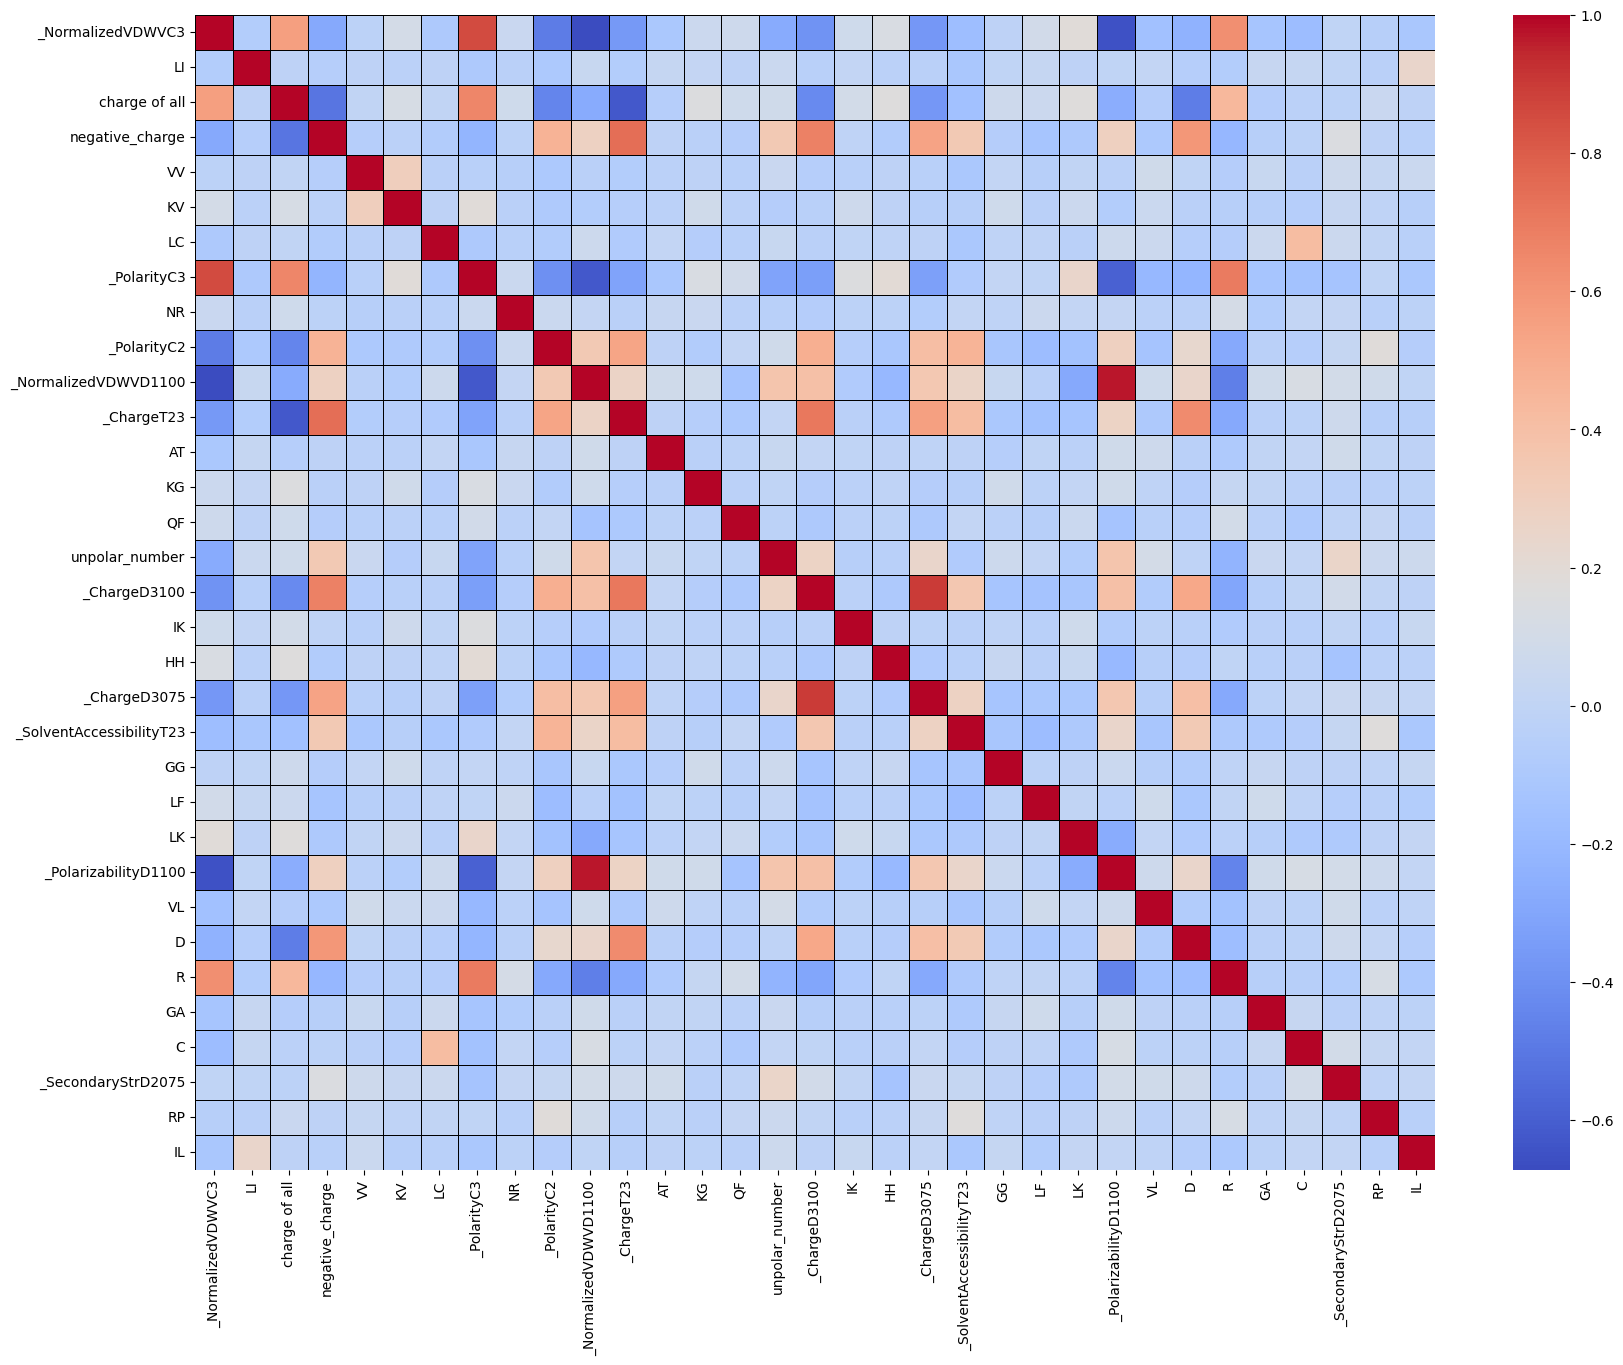

In [40]:
import seaborn as sns
import pandas as pd
import numpy as np

feature_selected_df = df[importance_final_df["Feature"]]

# 计算特征之间的相关性
corr = feature_selected_df.corr()

# 创建一个新的图形，你可以根据需要调整图形的大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm',
            linewidths=0.5, # 添加边框
            linecolor='black') # 边框颜色

plt.savefig("C:/Users/Lenovo/Desktop/new_study/CNS/output/XGBoost_heatmap.png")
# 显示图形
plt.show()

In [41]:
# 保存结果到 CSV 文件
importance_final_df.to_csv("C:/Users/Lenovo/Desktop/new_study/CNS/output/XGBoost_importance.csv", index=False)
evaluation_final_df.to_csv("C:/Users/Lenovo/Desktop/new_study/CNS/output/XGBoost_evaluation.csv", index=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18112\2408213141.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_final_df, palette='viridis')


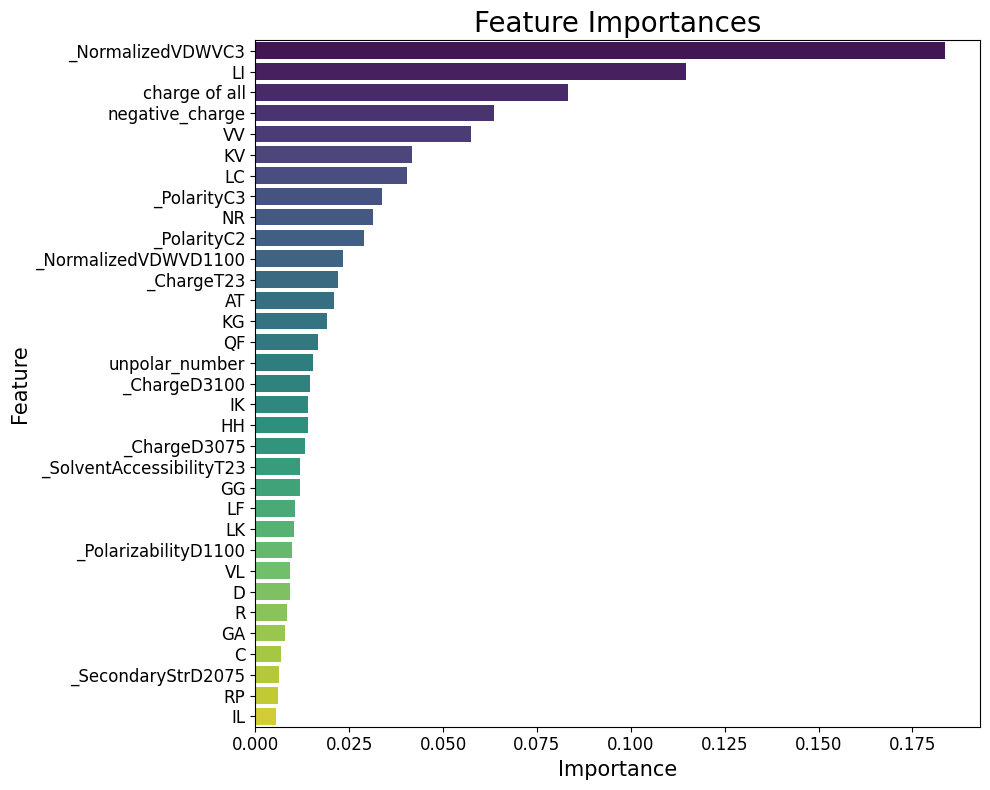

In [42]:
# 按照Importance列排序，大的值在上面
importance_final_df = importance_final_df.sort_values(by='Importance', ascending=False)

# 设置图形大小
plt.figure(figsize=(10, 8))

# 使用seaborn的barplot函数创建一个横向的柱状图，加入颜色映射
sns.barplot(x='Importance', y='Feature', data=importance_final_df, palette='viridis')

plt.title('Feature Importances', fontsize=20)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 自动调整布局
plt.tight_layout()

plt.savefig(r'C:\Users\Lenovo\Desktop\new_study\CNS\output\XGBoost_figure.png')
# 显示图形
plt.show()